# **Setting up a spark session**

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [4]:
!pip install -q findspark
!pip install pyspark==3.0.0

     |████████████████████████████████| 204.7 MB 22 kB/s 
     |████████████████████████████████| 198 kB 58.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=0da1cde0a57f26672e439ba2b46c8ccf8f71b9deba1d120d82af5f930d0b305c
  Stored in directory: /root/.cache/pip/wheels/4e/c5/36/aef1bb711963a619063119cc032176106827a129c0be20e301
Successfully built pyspark


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
from pyspark.sql import SparkSession

In [7]:
APP_NAME = "DSCI632Project_Kriti"

In [8]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [9]:
spark

### **Objective** : This notebook is an attempt to gain some insights into some of the most frequently discussed topics about Harry Potter Movie series and its adaptation from the novels by doing exploratory data anlalysis on Harry Potter movies dataset.

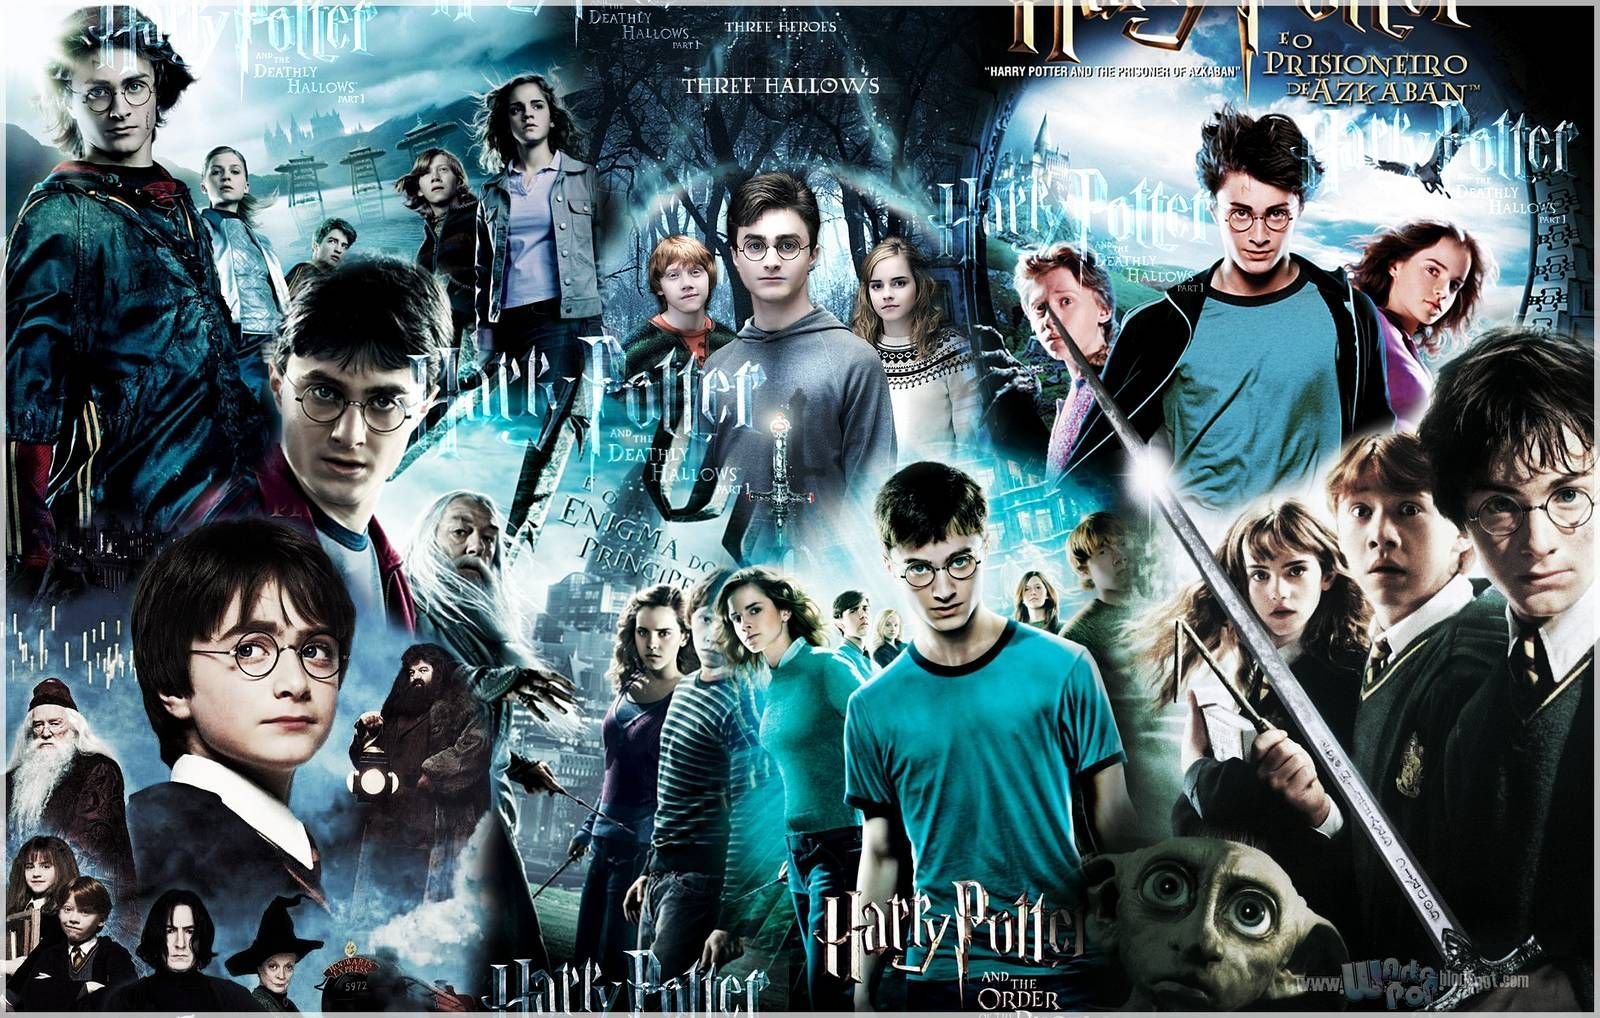

In [10]:
from IPython.display import Image
Image(filename='/content/gdrive/My Drive/DSCI632/Project/Images/Image1.jpeg', width=1000) 

# **Importing libraries**

In [11]:
import pandas as pd
from pyspark.sql.functions import col,isnan, when, count, row_number, sumDistinct, desc
import pyspark.sql.functions as f
from functools import reduce
from operator import or_
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator

In [12]:
import seaborn as sns; sns.set(style='ticks', color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# **Creating Dataframes**

In [13]:
characters_df = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Characters.csv')
dialogue_df   = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Dialogue.csv')
spell_df      = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Spells.csv')
movie_df      = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Movies.csv')
place_df      = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Places.csv')
chapter_df    = spark.read.options(header = True, inferSchema=True, Truncate = False).csv('/content/gdrive/My Drive/DSCI632/Project/Harry_Potter_Movies/Chapters.csv')

# **Data Preparation and Cleaning**

Step 1 - Go through the schema of each table

Step 2 - Look at the top 5 items for each table to get a glimse of what the data would look like

Step 3 - Check for Null/Nan/0 values.



In [14]:
characters_df.printSchema()
characters_df.show(5)
characters_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in characters_df.columns]).show() # Check null value

root
 |-- Character ID: integer (nullable = true)
 |-- Character Name: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- House: string (nullable = true)
 |-- Patronus: string (nullable = true)
 |-- Wand (Wood): string (nullable = true)
 |-- Wand (Core): string (nullable = true)

+------------+----------------+--------------------+------+----------+--------------------+-----------+------------------+
|Character ID|  Character Name|             Species|Gender|     House|            Patronus|Wand (Wood)|       Wand (Core)|
+------------+----------------+--------------------+------+----------+--------------------+-----------+------------------+
|           1|    Harry Potter|               Human|  Male|Gryffindor|                Stag|      Holly|   Phoenix Feather|
|           2|     Ron Weasley|               Human|  Male|Gryffindor|Jack Russell Terrier|       null|              null|
|           3|Hermione Granger|               Hu

In [15]:
dialogue_df.printSchema()
dialogue_df.show(5)
dialogue_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dialogue_df.columns]).show() # Check null value

root
 |-- Dialogue ID: integer (nullable = true)
 |-- Chapter ID: integer (nullable = true)
 |-- Place ID: integer (nullable = true)
 |-- Character ID: integer (nullable = true)
 |-- Dialogue: string (nullable = true)

+-----------+----------+--------+------------+--------------------+
|Dialogue ID|Chapter ID|Place ID|Character ID|            Dialogue|
+-----------+----------+--------+------------+--------------------+
|          1|         1|       8|           4|I should have kno...|
|          2|         1|       8|           7|Good evening, Pro...|
|          3|         1|       8|           4|I'm afraid so, Pr...|
|          4|         1|       8|           7|        And the boy?|
|          5|         1|       8|           4|Hagrid is bringin...|
+-----------+----------+--------+------------+--------------------+
only showing top 5 rows

+-----------+----------+--------+------------+--------+
|Dialogue ID|Chapter ID|Place ID|Character ID|Dialogue|
+-----------+----------+--------

In [16]:
spell_df.printSchema()
spell_df.show(5)
spell_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spell_df.columns]).show() # Check null value

root
 |-- Spell ID: integer (nullable = true)
 |-- Incantation: string (nullable = true)
 |-- Spell Name: string (nullable = true)
 |-- Effect: string (nullable = true)
 |-- Light: string (nullable = true)

+--------+----------------+--------------------+--------------------+--------+
|Spell ID|     Incantation|          Spell Name|              Effect|   Light|
+--------+----------------+--------------------+--------------------+--------+
|       1|           Accio|     Summoning Charm|   Summons an object|    null|
|       2|       Aguamenti|  Water-Making Spell|      Conjures water|Icy blue|
|       3|Alarte Ascendare|Launch an object ...|Rockets target up...|     Red|
|       4|       Alohomora|     Unlocking Charm|      Unlocks target|    Blue|
|       5|   Arania Exumai|Spider repelling ...|      Repels spiders|    Blue|
+--------+----------------+--------------------+--------------------+--------+
only showing top 5 rows

+--------+-----------+----------+------+-----+
|Spell ID|

In [17]:
movie_df.printSchema()
movie_df.show(5)
movie_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in movie_df.columns]).show() # Check null value

root
 |-- Movie ID: integer (nullable = true)
 |-- Movie Title: string (nullable = true)
 |-- Release Year: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- Budget: string (nullable = true)
 |-- Box Office: string (nullable = true)

+--------+--------------------+------------+-------+-------------+---------------+
|Movie ID|         Movie Title|Release Year|Runtime|       Budget|     Box Office|
+--------+--------------------+------------+-------+-------------+---------------+
|       1|Harry Potter and ...|        2001|    152|$125,000,000 |$1,002,000,000 |
|       2|Harry Potter and ...|        2002|    161|$100,000,000 |  $880,300,000 |
|       3|Harry Potter and ...|        2004|    142|$130,000,000 |  $796,700,000 |
|       4|Harry Potter and ...|        2005|    157|$150,000,000 |  $896,400,000 |
|       5|Harry Potter and ...|        2007|    138|$150,000,000 |  $942,000,000 |
+--------+--------------------+------------+-------+-------------+---------------

In [18]:
place_df.printSchema()
place_df.show(5)
place_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in place_df.columns]).show() # Check null value

root
 |-- Place ID: integer (nullable = true)
 |-- Place Name: string (nullable = true)
 |-- Place Category: string (nullable = true)

+--------+--------------------+--------------+
|Place ID|          Place Name|Place Category|
+--------+--------------------+--------------+
|       1|   Flourish & Blotts|  Diagon Alley|
|       2|Gringotts Wizardi...|  Diagon Alley|
|       3|     Knockturn Alley|  Diagon Alley|
|       4|         Ollivanders|  Diagon Alley|
|       5|  The Leaky Cauldron|  Diagon Alley|
+--------+--------------------+--------------+
only showing top 5 rows

+--------+----------+--------------+
|Place ID|Place Name|Place Category|
+--------+----------+--------------+
|       0|         0|             0|
+--------+----------+--------------+



In [19]:
chapter_df.printSchema()
chapter_df.show(5)
chapter_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in chapter_df.columns]).show() # Check null value

root
 |-- Chapter ID: integer (nullable = true)
 |-- Chapter Name: string (nullable = true)
 |-- Movie ID: integer (nullable = true)
 |-- Movie Chapter: integer (nullable = true)

+----------+-------------------+--------+-------------+
|Chapter ID|       Chapter Name|Movie ID|Movie Chapter|
+----------+-------------------+--------+-------------+
|         1|  Doorstep Delivery|       1|            1|
|         2|The Vanishing Glass|       1|            2|
|         3|Letters from No One|       1|            3|
|         4| Keeper of the Keys|       1|            4|
|         5|       Diagon Alley|       1|            5|
+----------+-------------------+--------+-------------+
only showing top 5 rows

+----------+------------+--------+-------------+
|Chapter ID|Chapter Name|Movie ID|Movie Chapter|
+----------+------------+--------+-------------+
|         0|           0|       0|            0|
+----------+------------+--------+-------------+



Since there is not 'Null' or 'Nan' or '0'  value in the 'ID' column of all the dataframes, therefore, we are keeping the dataframe as it is wihtout worrying about null/nan/0 in the other column values.

**Step 4: Clean the data**

4.1) Rename the Wand (Core) column to Wand then create a new variable for this dataframe.

In [20]:
characters = characters_df.withColumnRenamed('Wang(Core)', 'Wand')
characters.show(5)

+------------+----------------+--------------------+------+----------+--------------------+-----------+------------------+
|Character ID|  Character Name|             Species|Gender|     House|            Patronus|Wand (Wood)|       Wand (Core)|
+------------+----------------+--------------------+------+----------+--------------------+-----------+------------------+
|           1|    Harry Potter|               Human|  Male|Gryffindor|                Stag|      Holly|   Phoenix Feather|
|           2|     Ron Weasley|               Human|  Male|Gryffindor|Jack Russell Terrier|       null|              null|
|           3|Hermione Granger|               Human|Female|Gryffindor|               Otter|       Vine|Dragon Heartstring|
|           4|Albus Dumbledore|               Human|  Male|Gryffindor|             Phoenix|      Elder|Thestral Tail Hair|
|           5|   Rubeus Hagrid|Half-Human/Half-G...|  Male|Gryffindor|                null|        Oak|              null|
+------------+--

4.2) Removing the dollar sign for the Movie df to perform later calculation.

In [21]:
movie_df = movie_df.withColumn('Box Office', f.regexp_replace(f.col('Box Office'), '[\$#,]', ''))\
                   .withColumn('Budget', f.regexp_replace(f.col('Budget'), '[\$#,]', ''))
movie_df.show()

+--------+--------------------+------------+-------+----------+-----------+
|Movie ID|         Movie Title|Release Year|Runtime|    Budget| Box Office|
+--------+--------------------+------------+-------+----------+-----------+
|       1|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
|       2|Harry Potter and ...|        2002|    161|100000000 | 880300000 |
|       3|Harry Potter and ...|        2004|    142|130000000 | 796700000 |
|       4|Harry Potter and ...|        2005|    157|150000000 | 896400000 |
|       5|Harry Potter and ...|        2007|    138|150000000 | 942000000 |
|       6|Harry Potter and ...|        2009|    153|250000000 | 943200000 |
|       7|Harry Potter and ...|        2010|    146|200000000 | 976900000 |
|       8|Harry Potter and ...|        2011|    130|250000000 |1342000000 |
+--------+--------------------+------------+-------+----------+-----------+



# **Exploratory data analysis**
*   Query data from the table to answer some basic questions
*   Explore relationship between columns using scatter plots, bar charts etc.
*   Make a note of interesting insights from the exploratory analysis
*   Converting payspark dataframe to pandas dataframe to visualize the results.
*   Explore distributions of numeric columns using histograms etc.

In [22]:
%who DataFrame

chapter_df	 characters	 characters_df	 dialogue_df	 movie_df	 place_df	 spell_df	 


### **1) Which movie has the most runtime?**

In [23]:
max_runtime = movie_df.select('Movie Title', 'Runtime')
max_runtime.agg({'Movie Title':'max','Runtime': 'max'}).show(truncate = False)

+----------------------------------------+------------+
|max(Movie Title)                        |max(Runtime)|
+----------------------------------------+------------+
|Harry Potter and the Prisoner of Azkaban|161         |
+----------------------------------------+------------+



### ***2) Lets first explore the box office revenue and budget for each movie using barchart and line chart***

In [24]:
#converting pyspark dataframe to padnas dataframe to use matplotlib for visualization
movie_pd = movie_df.toPandas() 
movie_pd['Budget in million'] = movie_pd['Budget'].apply(lambda x: int(str(x)[0:3]))
movie_pd['Box Office in million'] = movie_pd['Box Office'].apply(lambda x: round(int(str(x).replace(',',''))/1e6,0))
movie_pd['Profit in million'] = movie_pd['Box Office in million'] - movie_pd['Budget in million'] 
movie_pd.head()

,Movie ID,Movie Title,Release Year,Runtime,Budget,Box Office,Budget in million,Box Office in million,Profit in million
0,1,Harry Potter and the Philosopher's Stone,2001,152,125000000,1002000000,125,1002.0,877.0
1,2,Harry Potter and the Chamber of Secrets,2002,161,100000000,880300000,100,880.0,780.0
2,3,Harry Potter and the Prisoner of Azkaban,2004,142,130000000,796700000,130,797.0,667.0
3,4,Harry Potter and the Goblet of Fire,2005,157,150000000,896400000,150,896.0,746.0
4,5,Harry Potter and the Order of the Phoenix,2007,138,150000000,942000000,150,942.0,792.0


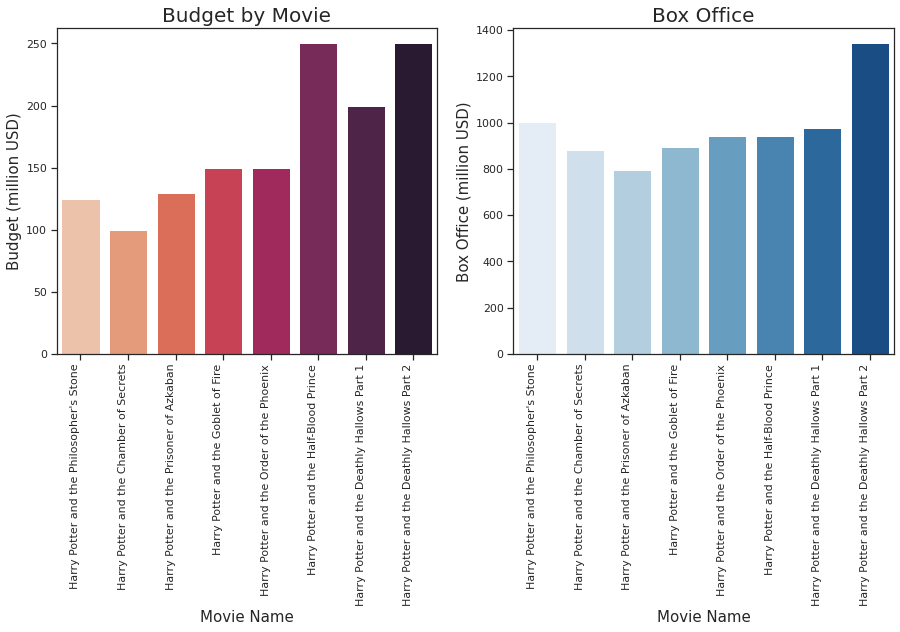

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='Movie Title',y='Budget in million', data=movie_pd, palette = 'rocket_r', ax=axes[0])
axes[0].set_xlabel('Movie Name', fontsize = '15')
axes[0].set_ylabel('Budget (million USD)', fontsize = '15')
axes[0].set_title('Budget by Movie', fontsize = '20')

sns.barplot(x='Movie Title',y='Box Office in million', data=movie_pd, palette = 'Blues', ax=axes[1])
axes[1].set_xlabel('Movie Name', fontsize = '15')
axes[1].set_ylabel('Box Office (million USD)', fontsize = '15')
axes[1].set_title('Box Office',  fontsize = '20')

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='right')

plt.show()


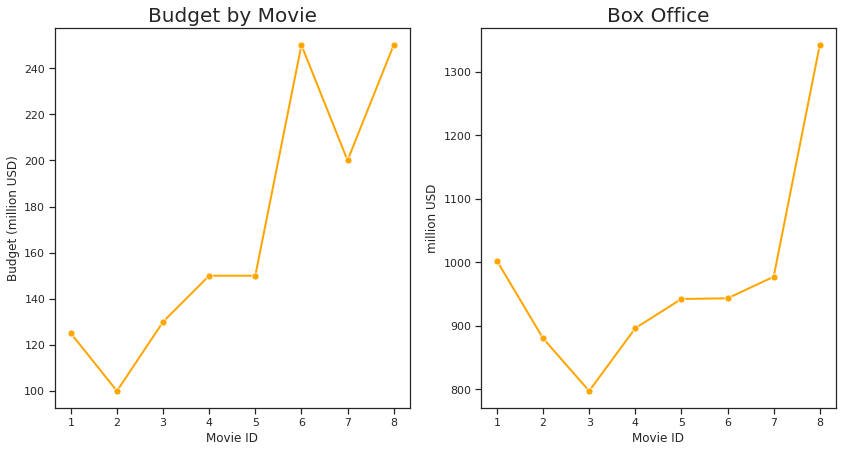

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(x='Movie ID',y='Budget in million', data=movie_pd, color = 'orange', marker = 'o', markersize = 7, ax=axes[0],lw = 2)
axes[0].set_xlabel('Movie ID')
axes[0].set_ylabel('Budget (million USD)')
axes[0].set_title('Budget by Movie', fontsize = '20')
sns.lineplot(x='Movie ID',y='Box Office in million', data=movie_pd, color = 'orange', marker = 'o', markersize = 7, ax=axes[1],lw = 2)
axes[1].set_xlabel('Movie ID')
axes[1].set_ylabel('million USD')
axes[1].set_title('Box Office', fontsize = '20')

plt.show()

**Result:** The budget of movie-id 6 & 8 is approximately same but the movie no 8 is the most successfull movie at the box office

### ***3) Analyze the profit made by each movie***

In [27]:
Profit_analysis = pd.melt(movie_pd[['Movie ID','Budget in million', 'Box Office in million',
       'Profit in million']].copy() , id_vars='Movie ID', var_name='Financial', value_name='Amount in million USD')

<Figure size 3960x1800 with 0 Axes>

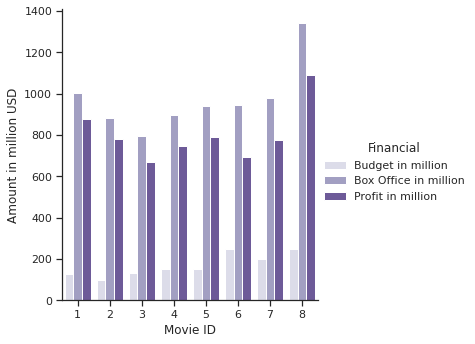

In [28]:
plt.figure(figsize = (55,25))
sns.catplot(x='Movie ID', y='Amount in million USD', hue='Financial', data = Profit_analysis, kind='bar', palette = 'Purples')

**Result:** Movie no 8 is the most successfull movie among the series, as its profit amount is more than One thousand million dollars.

### **4) Find top 10 characters which had the most dialogue display(word count).**

In [30]:
dia = dialogue_df.withColumn('Total Word in Dialogue', f.length('Dialogue'))
dia_selected = dia.select('Character ID', 'Total Word in Dialogue')
dia_selected = dia_selected.groupBy('Character ID').sum('Total Word in Dialogue').sort('sum(Total Word in Dialogue)', ascending = False)
dia_selected.show(10)

+------------+---------------------------+
|Character ID|sum(Total Word in Dialogue)|
+------------+---------------------------+
|           1|                      74360|
|           4|                      41859|
|           3|                      41568|
|           2|                      36898|
|           5|                      18528|
|           6|                      13201|
|           8|                      11950|
|           7|                      10965|
|          11|                      10493|
|           9|                       9070|
+------------+---------------------------+
only showing top 10 rows



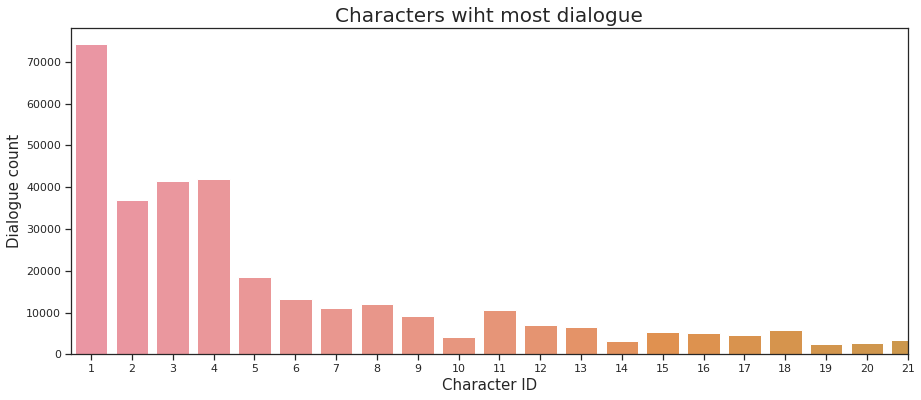

In [31]:
# Convert to panda dataframe and plot
dia_pd = dia_selected.toPandas()

# Plot the responses for different events and regions
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)

q4_plot = sns.barplot(x = 'Character ID', y = 'sum(Total Word in Dialogue)', data = dia_pd)

q4_plot.set_xlabel('Character ID', fontsize = 15)
q4_plot.set_ylabel('Dialogue count', fontsize = 15)
q4_plot.set_title('Characters wiht most dialogue', fontsize = 20)

# change the limits of X-axis
ax.set_xlim(-0.5, 20)
plt.show()

**Result:**
According to the bar chart, character 1 has the most dialogue, which exceeds 70000 words. The second is character 4; character 4 has over 40000 words. Character 3 is slightly less than character 4. The fourth was character 2, which has over 30000 words. And the rest of the characters have only less than 20000 words

### **5) To calculate total number of members for each house.**

In [32]:
characters_clean = characters_df.na.drop(subset=["House"])
characters_in_house = characters_clean.groupBy('House').count().sort('count', ascending = False)
characters_in_house.show(truncate = False)

+----------------------------+-----+
|House                       |count|
+----------------------------+-----+
|Gryffindor                  |31   |
|Slytherin                   |20   |
|Ravenclaw                   |12   |
|Hufflepuff                  |8    |
|Durmstrang Institute        |2    |
|Beauxbatons Academy of Magic|2    |
+----------------------------+-----+



Text(0.5, 1.0, 'Total members in each house')

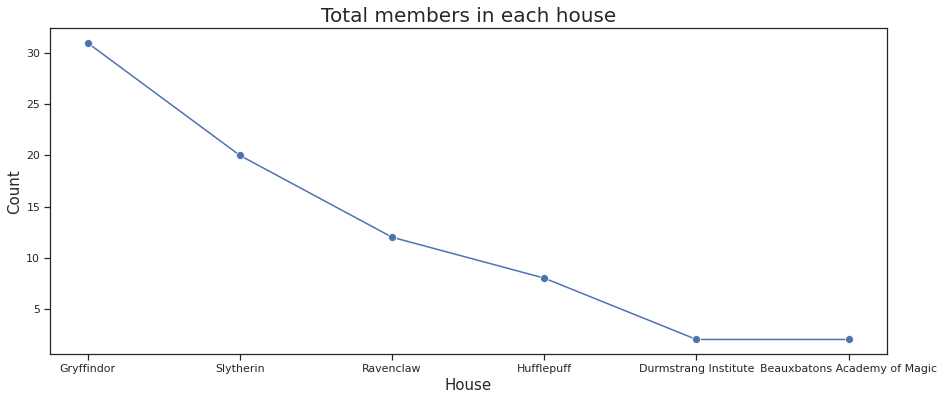

In [33]:
# Convert to panda dataframe and plot
characters_in_house_pd = characters_in_house.toPandas()

# Plot the responses for different events and regions
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)

q5_plot = sns.lineplot(x = 'House', y = 'count', marker = 'o', markersize = 8, data = characters_in_house_pd)
q5_plot.set_xlabel('House', fontsize = 15)
q5_plot.set_ylabel('Count', fontsize = 15)
q5_plot.set_title('Total members in each house', fontsize = 20)

**Result:**According to the result, over 50% of the characters didn't belong to any houses. The Gryffindor has the most characters overall. The second is Slytherin, and the third is Ravenclaw.

### **6) Find the distribution of characters by House based on gender.**

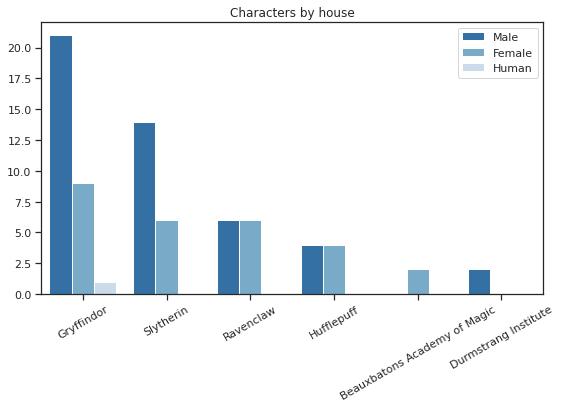

In [34]:
characters_pd = characters_df.toPandas()
g2 = sns.countplot(x='House',data= characters_pd,hue='Gender', palette = 'Blues_r')
g2.set(title='Characters by house')
g2.set(xlabel=None)
g2.set(ylabel=None)
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.show()

**Result:** We can see that the Gryffindor and Slytherine has more male members whereas, Hufflepuff anf Ravenclaw consist of equal number of male & female members and none of them is human. 

### **8) What's the most popular words in spell names?**

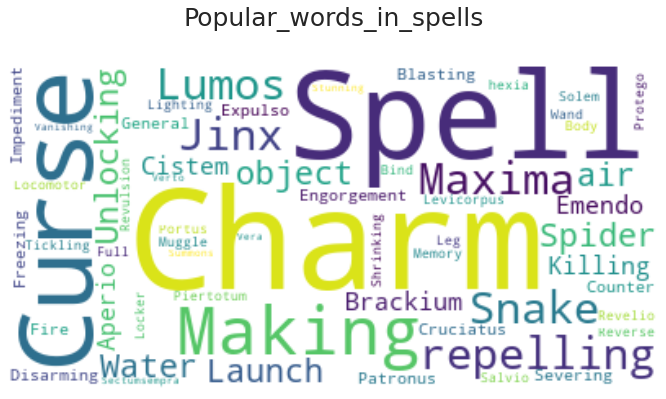

In [35]:
# Drop null values
spell_df1 = spell_df.dropna()

# Transform to pandas dataframe
spell_pd = spell_df1.toPandas() 

spells_data = spell_pd.rename(columns = {'Spell Name': 'spell_name'}, inplace = False)

text = ' '.join(i for i in spells_data.spell_name)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular_words_in_spells', fontsize = 25, pad = 40)
plt.show()

### **Q9. What words appear the most in dialogue?**

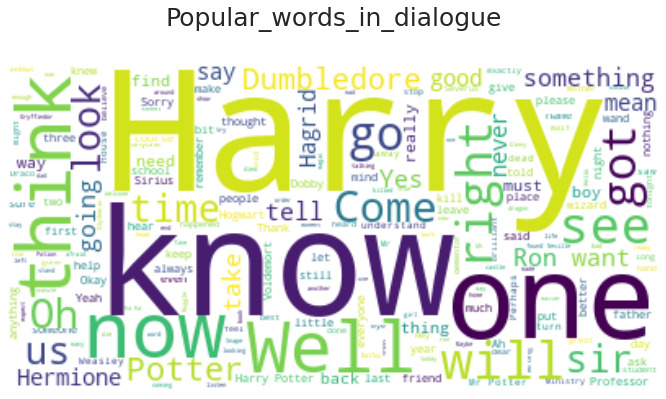

In [36]:
# Transform to pandas dataframe
dialogue_pd = dialogue_df.toPandas()

Dialogue = dialogue_pd.rename(columns = {'Dialogue': 'dialogue'}, inplace = False)

text = ' '.join(i for i in dialogue_pd.Dialogue)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular_words_in_dialogue', fontsize = 25, pad = 40)
plt.show()

# **Validating the 3 hypothesis**

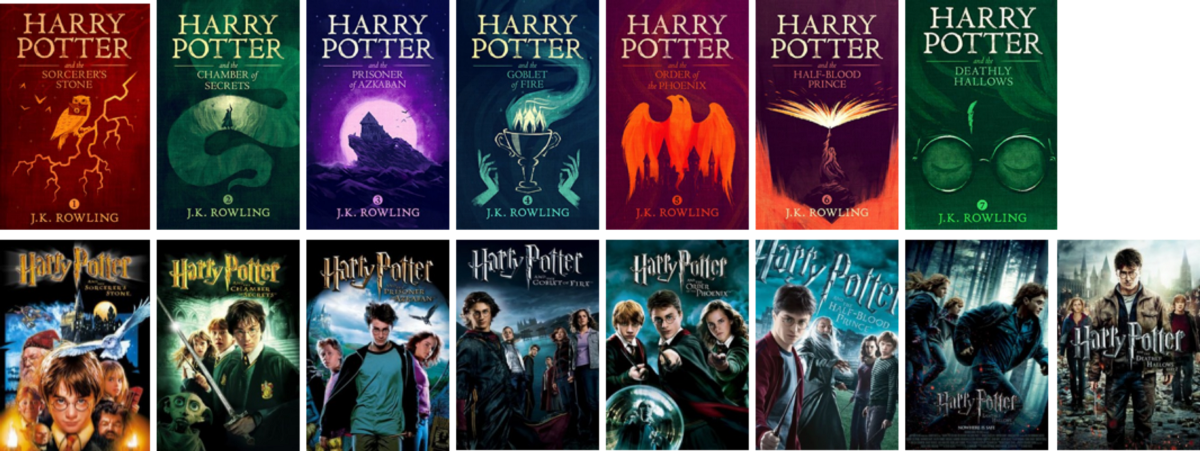

In [37]:
from IPython.display import Image
Image(filename='/content/gdrive/My Drive/DSCI632/Project/Images/Image2.png', width=900) 

### **Hypothesis 1: Adaptation of book chapters into movies**
With this data we explore which movies condense the most book chapters within 1 hour of runtime and which are the top 2 and bottom 2 most densed movie chapter. We also try to draw a correlation between the revenue and the number of chapters per 1 hour of runtime.

In [38]:
#For the review of book adaptation, we need Movies and Chapters tables
Book_adaptation_df_raw = chapter_df.join(movie_df, how = 'left', on = 'Movie ID')
Book_adaptation_df_raw.show(5)

+--------+----------+-------------------+-------------+--------------------+------------+-------+----------+-----------+
|Movie ID|Chapter ID|       Chapter Name|Movie Chapter|         Movie Title|Release Year|Runtime|    Budget| Box Office|
+--------+----------+-------------------+-------------+--------------------+------------+-------+----------+-----------+
|       1|         1|  Doorstep Delivery|            1|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
|       1|         2|The Vanishing Glass|            2|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
|       1|         3|Letters from No One|            3|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
|       1|         4| Keeper of the Keys|            4|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
|       1|         5|       Diagon Alley|            5|Harry Potter and ...|        2001|    152|125000000 |1002000000 |
+--------+----------+-----------

In [39]:
# We now try to see the all the Movie chapter in Movie ID = 1,
Book_adaptation_df_1st_movie = Book_adaptation_df_raw[Book_adaptation_df_raw['Movie ID'] == 1]
Book_adaptation_df_1st_movie.show(5, truncate = False)

+--------+----------+-------------------+-------------+----------------------------------------+------------+-------+----------+-----------+
|Movie ID|Chapter ID|Chapter Name       |Movie Chapter|Movie Title                             |Release Year|Runtime|Budget    |Box Office |
+--------+----------+-------------------+-------------+----------------------------------------+------------+-------+----------+-----------+
|1       |1         |Doorstep Delivery  |1            |Harry Potter and the Philosopher's Stone|2001        |152    |125000000 |1002000000 |
|1       |2         |The Vanishing Glass|2            |Harry Potter and the Philosopher's Stone|2001        |152    |125000000 |1002000000 |
|1       |3         |Letters from No One|3            |Harry Potter and the Philosopher's Stone|2001        |152    |125000000 |1002000000 |
|1       |4         |Keeper of the Keys |4            |Harry Potter and the Philosopher's Stone|2001        |152    |125000000 |1002000000 |
|1       |5  

In [40]:
# Lets see the number of chapters group by each movie
Chapters_by_movie_df = chapter_df.groupBy('Movie ID').agg(f.count('Chapter ID').alias('Number of chapters'))
#print(Chapters_by_movie_df.show(10, truncate=False))
Chapters_by_movie_details_df = Chapters_by_movie_df.join(movie_df, how = 'left', on = 'Movie ID')
Chapters_by_movie_details_df = Chapters_by_movie_details_df.withColumn('Runtime_hours', col('Runtime')/60.0)\
                                                           .withColumn('Chapters_over_hour', col('Number of chapters')/col('Runtime_hours'))
print(Chapters_by_movie_details_df.show(10, truncate=False))

+--------+------------------+-------------------------------------------+------------+-------+----------+-----------+------------------+------------------+
|Movie ID|Number of chapters|Movie Title                                |Release Year|Runtime|Budget    |Box Office |Runtime_hours     |Chapters_over_hour|
+--------+------------------+-------------------------------------------+------------+-------+----------+-----------+------------------+------------------+
|1       |34                |Harry Potter and the Philosopher's Stone   |2001        |152    |125000000 |1002000000 |2.533333333333333 |13.421052631578949|
|6       |26                |Harry Potter and the Half-Blood Prince     |2009        |153    |250000000 |943200000  |2.55              |10.19607843137255 |
|3       |33                |Harry Potter and the Prisoner of Azkaban   |2004        |142    |130000000 |796700000  |2.3666666666666667|13.943661971830986|
|5       |27                |Harry Potter and the Order of the P

In [41]:
# Lets see the most 3 densed movie
Chapters_by_movie_details_df.orderBy('Chapters_over_hour', ascending=False).show(10)

+--------+------------------+--------------------+------------+-------+----------+-----------+------------------+------------------+
|Movie ID|Number of chapters|         Movie Title|Release Year|Runtime|    Budget| Box Office|     Runtime_hours|Chapters_over_hour|
+--------+------------------+--------------------+------------+-------+----------+-----------+------------------+------------------+
|       3|                33|Harry Potter and ...|        2004|    142|130000000 | 796700000 |2.3666666666666667|13.943661971830986|
|       1|                34|Harry Potter and ...|        2001|    152|125000000 |1002000000 | 2.533333333333333|13.421052631578949|
|       2|                36|Harry Potter and ...|        2002|    161|100000000 | 880300000 | 2.683333333333333|13.416149068322982|
|       8|                26|Harry Potter and ...|        2011|    130|250000000 |1342000000 |2.1666666666666665|              12.0|
|       5|                27|Harry Potter and ...|        2007|    13

Text(0.5, 0, 'Book-Movie Adaptation')

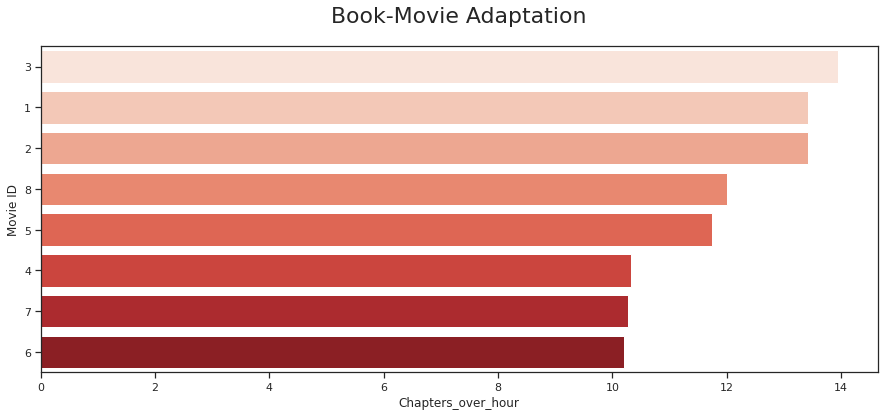

In [42]:
Chapter_by_movie_pd = Chapters_by_movie_details_df.toPandas()

fig, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.barplot(x='Chapters_over_hour',y='Movie ID', data=Chapter_by_movie_pd, palette = 'Reds', orient = 'h'
           , order=Chapter_by_movie_pd.sort_values('Chapters_over_hour',ascending = False)['Movie ID'])
axes.set_xlabel('Chapters_over_hour')
axes.set_ylabel('Movie ID')
axes.set_title('Book-Movie Adaptation', y=0, pad=350, fontsize = '22')

**Result:** In the above chart, we can see that the most dense movies are actually the first 3 movies, while the longer book like book number 4 and 7 with a lot of content actually have less chapters per 1 hour of runtime. In this case, chapters per runtime might not be the best metrics to track how dense and how much content is crammed in each movie due to the difference in the length of the movies


In [43]:
#Chapter_by_movie_pd['Box Office'] = Chapter_by_movie_pd['Box Office'].str.replace(',','').astype(int)
Chapter_by_movie_pd['Budget'] = Chapter_by_movie_pd['Budget'].str.replace(',','').astype(int)
Chapter_by_movie_pd['Chapters_over_hour'] = Chapter_by_movie_pd['Chapters_over_hour'].astype(int)
Chapter_by_movie_pd['Runtime_hours'] = Chapter_by_movie_pd['Runtime_hours'].astype(int)

Text(0.5, 0, 'Movie adaptation')

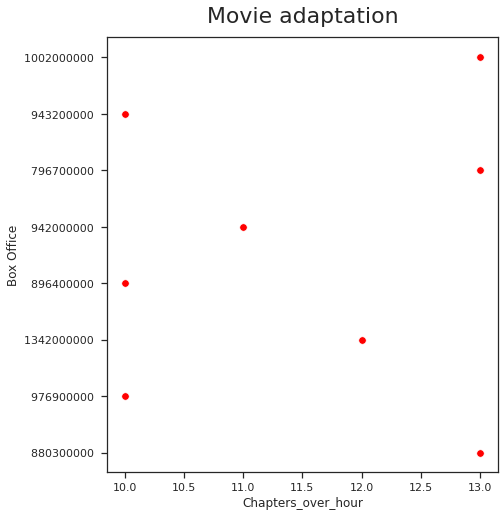

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(7, 8))

sns.scatterplot(x='Chapters_over_hour',y='Box Office',data=Chapter_by_movie_pd, color = 'red', s=55)
axes.set_xlabel('Chapters_over_hour')
axes.set_ylabel('Box Office')
axes.set_title('Movie adaptation', y=0, pad=450, fontsize = '22')

**Result:**
Same with comparing the movies in the bar chart, a scatter plot also shows no correlation whatsoever between the chapters per hour of run time and the box office. The data did not show correlation between the variables.

### **Hypothesis 2: Character arc and Character development**

Besides the golden trio, Luna Lovegood and Neville Longbottom & Draco Malfoy are the 3 members that are beloved by many. In this section we explore the number of dialogues and the number of words these the characters have over the course of the series. For comparison, we also add in the same statistics for Ginny Weasley, another member and a prominent side character to see the contrast.

In [45]:
# First lets join all tables that we need into one big data frame.
# We will need the following tables: Dialogue, Characters, Chapters, Movies

Dialogue_byChapters_df = dialogue_df.join(chapter_df, how = 'left', on = 'Chapter ID')
Dialogue_byChapters_byCharacters_df = Dialogue_byChapters_df.join(characters_df, how = 'left', on = 'Character ID')
Dialogue_byChapters_byCharacters_byMovies_df = Dialogue_byChapters_byCharacters_df.join(movie_df, how = 'left', on = 'Movie ID')

In [46]:
# look at our new joined dataframe
print(Dialogue_byChapters_byCharacters_byMovies_df.show(5, truncate = False))

#size of the new dataframe
print('Size:', (Dialogue_byChapters_byCharacters_byMovies_df.count(), len(Dialogue_byChapters_byCharacters_byMovies_df.columns)))

+--------+------------+----------+-----------+--------+------------------------------------------------------------------+-----------------+-------------+------------------+-------+------+----------+--------+-----------+------------------+----------------------------------------+------------+-------+----------+-----------+
|Movie ID|Character ID|Chapter ID|Dialogue ID|Place ID|Dialogue                                                          |Chapter Name     |Movie Chapter|Character Name    |Species|Gender|House     |Patronus|Wand (Wood)|Wand (Core)       |Movie Title                             |Release Year|Runtime|Budget    |Box Office |
+--------+------------+----------+-----------+--------+------------------------------------------------------------------+-----------------+-------------+------------------+-------+------+----------+--------+-----------+------------------+----------------------------------------+------------+-------+----------+-----------+
|1       |4           |1 

In [47]:
# Now we extract the columns we would be using, and create a proper name for this data frame
Selected_columns = ['Character Name', 'Dialogue', 'Movie ID', 'Movie Title', 'Runtime']
Characters_growth_df = Dialogue_byChapters_byCharacters_byMovies_df.select(Selected_columns)
Characters_growth_df.show(5, truncate = False)

+------------------+------------------------------------------------------------------+--------+----------------------------------------+-------+
|Character Name    |Dialogue                                                          |Movie ID|Movie Title                             |Runtime|
+------------------+------------------------------------------------------------------+--------+----------------------------------------+-------+
|Albus Dumbledore  |I should have known that you would be here...Professor McGonagall.|1       |Harry Potter and the Philosopher's Stone|152    |
|Minerva McGonagall|Good evening, Professor Dumbledore. Are the rumours true, Albus?  |1       |Harry Potter and the Philosopher's Stone|152    |
|Albus Dumbledore  |I'm afraid so, Professor. The good, and the bad.                  |1       |Harry Potter and the Philosopher's Stone|152    |
|Minerva McGonagall|And the boy?                                                      |1       |Harry Potter and the Philoso

In [48]:
# Lets add a new column that counts the number of words per each dialogue spoken 
Characters_growth_df = Characters_growth_df.withColumn('Number of words', f.size(f.split(f.col('Dialogue'), ' ')))
Characters_growth_df.orderBy('Number of words', ascending=False).show(5)

+----------------+--------------------+--------+--------------------+-------+---------------+
|  Character Name|            Dialogue|Movie ID|         Movie Title|Runtime|Number of words|
+----------------+--------------------+--------+--------------------+-------+---------------+
|   Rubeus Hagrid|That, Ron, is a h...|       3|Harry Potter and ...|    142|            192|
|Albus Dumbledore|Our Care of Magic...|       3|Harry Potter and ...|    142|            175|
|Albus Dumbledore|Today we acknowle...|       4|Harry Potter and ...|    157|            159|
|   Severus Snape|There will be no ...|       1|Harry Potter and ...|    152|            143|
|Albus Dumbledore|Another year, gon...|       1|Harry Potter and ...|    152|            137|
+----------------+--------------------+--------+--------------------+-------+---------------+
only showing top 5 rows



In [49]:
Characters_growth_df.select('Character Name').distinct().orderBy('Character Name').show(5)

+--------------------+
|      Character Name|
+--------------------+
|Aberforth Dumbledore|
|       Alastor Moody|
|    Albus Dumbledore|
|        Albus Potter|
|       Alecto Carrow|
+--------------------+
only showing top 5 rows



In [50]:
# Lets select only the dialogues from the 3 characters that we are interested in: Neville, Luna, Ginny, Draco Malfoy
str_list = ['%Neville%', '%Luna%', '%Ginny%', '%Draco%']
Characters_growth_DA_members_df = Characters_growth_df.filter(reduce(or_, [col('Character Name').like(s) for s in str_list]))
Characters_growth_DA_members_df.show(5)

+------------------+--------------------+--------+--------------------+-------+---------------+
|    Character Name|            Dialogue|Movie ID|         Movie Title|Runtime|Number of words|
+------------------+--------------------+--------+--------------------+-------+---------------+
|     Ginny Weasley|          Good luck.|       1|Harry Potter and ...|    152|              2|
|Neville Longbottom|     Trevor!  Sorry.|       1|Harry Potter and ...|    152|              3|
|      Draco Malfoy|It's true then, w...|       1|Harry Potter and ...|    152|             75|
|Neville Longbottom|Seamus, that pict...|       1|Harry Potter and ...|    152|              4|
|Neville Longbottom|The only problem ...|       1|Harry Potter and ...|    152|             10|
+------------------+--------------------+--------+--------------------+-------+---------------+
only showing top 5 rows



In [51]:
Side_characters_dialoge = Characters_growth_DA_members_df.groupBy('Movie ID', 'Character Name')\
                                                         .agg(f.sum('Number of words').alias('Number of words'), f.countDistinct('Dialogue').alias('Number of dialogue'))\
                                                         .orderBy('Movie ID')                                                                                                            
Side_characters_dialoge.show(5)
#Characters_growth_DA_members_df = Characters_growth_DA_members_df.withColumnRenamed('Number of words', )

+--------+------------------+---------------+------------------+
|Movie ID|    Character Name|Number of words|Number of dialogue|
+--------+------------------+---------------+------------------+
|       1|      Draco Malfoy|            202|                13|
|       1|     Ginny Weasley|              2|                 1|
|       1|Neville Longbottom|            110|                17|
|       2|Neville Longbottom|             44|                 7|
|       2|     Ginny Weasley|             28|                 3|
+--------+------------------+---------------+------------------+
only showing top 5 rows



Text(0.5, 1.0, 'Number of words')

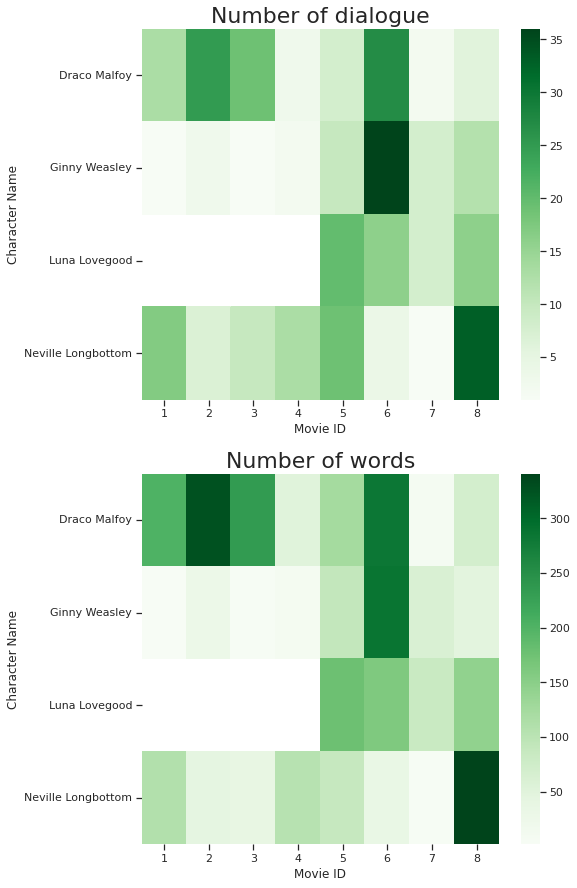

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(8, 15))
Side_characters_dialoge_pd = Side_characters_dialoge.toPandas()
sns.heatmap(Side_characters_dialoge_pd.pivot_table(values = 'Number of dialogue', index='Character Name',columns='Movie ID'), fmt='g', cmap = 'Greens', ax = axes[0])
axes[0].set_title('Number of dialogue', fontsize = '22')
sns.heatmap(Side_characters_dialoge_pd.pivot_table(values = 'Number of words', index='Character Name',columns='Movie ID'), fmt='g', cmap = 'Greens', ax = axes[1])
axes[1].set_title('Number of words', fontsize = '22')

**Result:**  From the above chart, we can clearly see a significant rise in appearance for Ginny in the sixth movie and Neville in the last movie. This is the moment their characters really plays significant role (Neville leading the Dumbledore Army after Harry left Hogwarts and Ginny with her love story with Harry).

Interestingly,there were no consistent increase in the presence of these characters movie on movie. Instead, we have a sudden spike here and there for these characters. My guess is JK Rowling did not have a clear path in mind for a vertical improvement for the characters but rather she put them where the story is heading. Luna actually has a more consistent appearance than both Ginny and Neville. May be this could be due to her innocence characters that make her a great point of view to tell the story from.

If we look at the difference in number of words and number of dialogue, we continue to see a stark difference between Luna and the rest. Neville is made out to be one of the most important sub characters due to his impressive heroic rise in the last book, but from the data shown here, Luna is actually the character that gets more focus from the filmmaker.

### **Hypothesis 3: Factors that determine the movies budget and their revenue**

We try to analyze budget level based on:
*   The number of dialogues (less dialogue, more actions and actions are more costly to make)
*   The number of places appear for the first time( more places more set needs to be built, but if the set is reused from the previous movies, no additional budget needed)
*   The movie length (the longer it is, the more shots needed to be taken) We also add in the revenue for each movie to see if there is any correlation between the revenue and the above factors.








In [53]:
# Lets join another table that would help to explore the movies budget factors and their revenue
# This table will consist of the following tables: Dialogue, Chapters, Movies, Places

Dialogue_bymovies_df = Dialogue_byChapters_df.join(movie_df, how = 'left', on = 'Movie ID')
Dialogue_bymovies_byplaces_df = Dialogue_bymovies_df.join(place_df, how = 'left', on = 'Place ID')
print(Dialogue_bymovies_byplaces_df.show(5, False))
print(Dialogue_bymovies_byplaces_df.columns)

+--------+--------+----------+-----------+------------+------------------------------------------------------------------+-----------------+-------------+----------------------------------------+------------+-------+----------+-----------+--------------+--------------+
|Place ID|Movie ID|Chapter ID|Dialogue ID|Character ID|Dialogue                                                          |Chapter Name     |Movie Chapter|Movie Title                             |Release Year|Runtime|Budget    |Box Office |Place Name    |Place Category|
+--------+--------+----------+-----------+------------+------------------------------------------------------------------+-----------------+-------------+----------------------------------------+------------+-------+----------+-----------+--------------+--------------+
|8       |1       |1         |1          |4           |I should have known that you would be here...Professor McGonagall.|Doorstep Delivery|1            |Harry Potter and the Philosopher's S

In [54]:
# Lets get the following metrics for each movie:
# Item 1. Revnue and Budget
# Item 2. The movie length
# Item 3. The number of places apprearing for the first time in each movies
# Item 4. The number of words spoken (less dialogue, more actions and actions are more costly to make)

# For Item 1, 2 we already have it in the Dialogue_bymovies_byplaces dataframe, 
# for item 3 we need to first get the first movie that the places appear, this can be done by getting the min movie ID of each places.
# This is done by sort_values of the movies group by place ID, place name to get the top 1 value

w2 = Window.partitionBy('Place ID').orderBy(col('Movie ID'))
Place_first_movie_df = Dialogue_bymovies_byplaces_df.select('Place ID','Place Name','Movie ID') \
                                                    .withColumn('row',row_number().over(w2)) \
                                                    .filter(col('row') == 1).drop('row')


In [55]:
print(Place_first_movie_df.show(10))
print('Size:', (Place_first_movie_df.count(), len(Place_first_movie_df.columns)))

+--------+--------------------+--------+
|Place ID|          Place Name|Movie ID|
+--------+--------------------+--------+
|      31|      Detention Room|       5|
|      65|   Unknown Classroom|       1|
|      53|     Ravenclaw Tower|       8|
|      34|First-Floor Girls...|       1|
|      28|           Corridors|       1|
|      26|    Charms Classroom|       1|
|      27|Clocktower Courtyard|       3|
|      44|             Library|       1|
|      12|      Lovegood House|       7|
|      22|The Three Broomst...|       3|
+--------+--------------------+--------+
only showing top 10 rows

None
Size: (74, 3)


In [56]:
# Now lets get the number of places that appeared first time in each movies
New_places_per_movies_df = Place_first_movie_df.groupBy('Movie ID')\
                                               .agg(f.count('Place ID').alias('New Places'))\
                                               .orderBy('Movie ID')
New_places_per_movies_df.show()

+--------+----------+
|Movie ID|New Places|
+--------+----------+
|       1|        27|
|       2|        11|
|       3|         8|
|       4|         7|
|       5|         6|
|       6|         6|
|       7|         6|
|       8|         3|
+--------+----------+



In [57]:
# Lets add a new column that counts the number of words per each dialogue spoken 

Dialogue_bymovies_byplaces_df = Dialogue_bymovies_byplaces_df.withColumn('Dialogue word count', f.size(f.split(f.col('Dialogue'), ' ')))
#print(Dialogue_bymovies_byplaces_df.show())
Words_per_movies_df = Dialogue_bymovies_byplaces_df.groupBy('Movie ID')\
                                               .agg(f.count('Dialogue word count').alias('Dialogue word count'))\
                                               .orderBy('Movie ID')
print(Words_per_movies_df.show())

+--------+-------------------+
|Movie ID|Dialogue word count|
+--------+-------------------+
|       1|                885|
|       2|                986|
|       3|                881|
|       4|                741|
|       5|               1157|
|       6|               1070|
|       7|               1012|
|       8|                712|
+--------+-------------------+

None


In [58]:
# For the final steps we join back to the Movies table (processed removed the dollar sign) to get a table we can perform analysis on

%who DataFrame # check which dataframe is available

Movies_no_of_words = movie_df.join(Words_per_movies_df, how='left', on='Movie ID')
Movies_no_of_words_new_places = Movies_no_of_words.join(New_places_per_movies_df, how = 'left', on = 'Movie ID')
Movies_no_of_words_new_places = Movies_no_of_words_new_places.withColumn('Runtime_hours', col('Runtime')/60.0).orderBy('Movie ID')
Movies_no_of_words_new_places.show()

Book_adaptation_df_1st_movie	 Book_adaptation_df_raw	 Chapter_by_movie_pd	 Chapters_by_movie_details_df	 Chapters_by_movie_df	 Characters_growth_DA_members_df	 Characters_growth_df	 Dialogue	 Dialogue_byChapters_byCharacters_byMovies_df	 
Dialogue_byChapters_byCharacters_df	 Dialogue_byChapters_df	 Dialogue_bymovies_byplaces_df	 Dialogue_bymovies_df	 New_places_per_movies_df	 Place_first_movie_df	 Profit_analysis	 Side_characters_dialoge	 Side_characters_dialoge_pd	 
Words_per_movies_df	 chapter_df	 characters	 characters_clean	 characters_df	 characters_in_house	 characters_in_house_pd	 characters_pd	 dia	 
dia_pd	 dia_selected	 dialogue_df	 dialogue_pd	 max_runtime	 movie_df	 movie_pd	 place_df	 spell_df	 
spell_df1	 spell_pd	 spells_data	 
+--------+--------------------+------------+-------+----------+-----------+-------------------+----------+------------------+
|Movie ID|         Movie Title|Release Year|Runtime|    Budget| Box Office|Dialogue word count|New Places|     Runtime_ho

In [59]:
# First we need to convert all columns to int to perform smooth charting
movies_words_places_pd = Movies_no_of_words_new_places.toPandas()
movies_words_places_pd['Budget'] = movies_words_places_pd['Budget'].str.replace(',','').astype(int)
movies_words_places_pd['Box Office'] = movies_words_places_pd['Box Office'].str.replace(',','').astype(int)
movies_words_places_pd['Runtime_hours'] = movies_words_places_pd['Runtime_hours'].astype(int)

Text(0.5, 0, 'Budget correlation with places and dialogue')

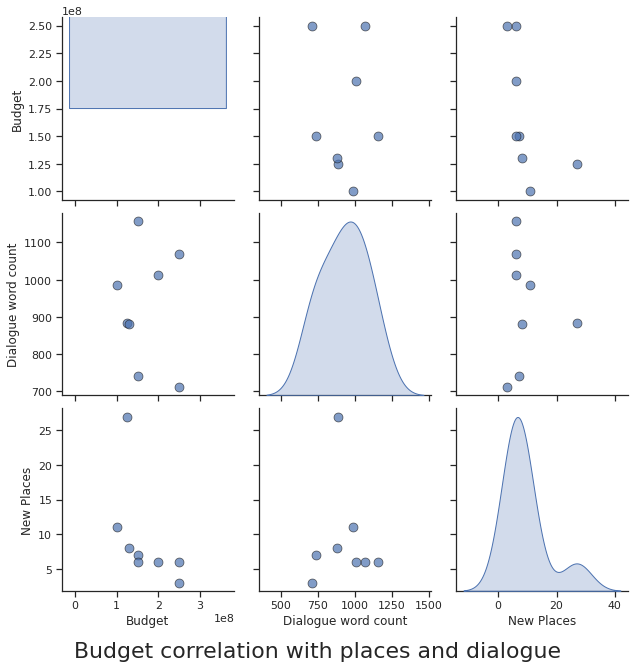

In [60]:
sns.pairplot(movies_words_places_pd[['Budget','Dialogue word count','New Places']],  diag_kind = 'kde',  
             plot_kws = {'alpha': 0.7, 's': 80, 'edgecolor': 'k'}, height = 3)

plt.suptitle('Budget correlation with places and dialogue', y=0, fontsize = '22')

Text(0.5, 0, 'Box office correlation with places and dialogue')

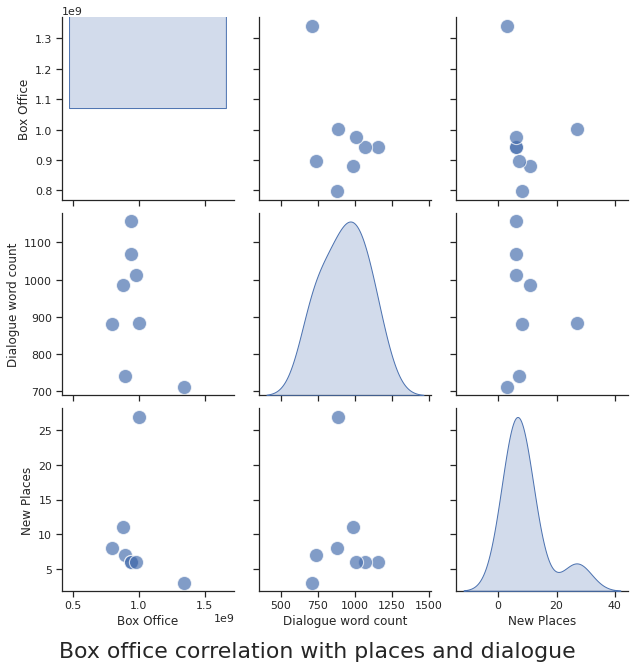

In [61]:
sns.pairplot(movies_words_places_pd[['Box Office','Dialogue word count','New Places']], diag_kind = 'kde',
             plot_kws = {'alpha': 0.7, 's': 200}, height = 3)

plt.suptitle('Box office correlation with places and dialogue', y=0, fontsize = '22')

**Result:** *Our hypothesis did not turn out to be true* as the budget/box office did not show any correlation with the dialogue word count and number of new places per movie. Further data needs to be gathered to answer such question.

# **Inferences and Conclusion**
Our analysis have successfully explored a lot about the Harry Potter movie series. In all of our 3 initial hypothesis, only 1 turns out to be a meaningful analysis i.e. only Hopythesis-2(the role of the 4 side characters) holds true.